In [1]:
import numpy as np
import pandas as pd


from astropy.io import fits
import matplotlib.pyplot as plt
import plothist

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: The recommended fonts to use plothist were not found. You can install them by typing 'install_latin_modern_fonts' in your terminal. If it still does not work, please check the documentation at https://plothist.readthedocs.io/en/latest/usage/font_installation.html
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
from slab import Slab
from bias_models import BiasModel
from theta_model import ThetaModel
from model_comparison import ModelComparison

In [3]:
halo_data = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/halos.fits")
halo_data = pd.DataFrame(halo_data[1].data)
halo_data.columns

Index(['ix', 'iy', 'iz', 'x', 'y', 'z', 'mass'], dtype='object')

In [4]:
delta_m = fits.open("/Users/elyasfarah/Documents/Galaxy Bias/deltam.fits")
delta_m = pd.DataFrame(delta_m[1].data)
delta_m.columns

Index(['ix', 'iy', 'iz', 'dens'], dtype='object')

In [5]:
# extracting each of the halos and matter corrdinates

x_halo = halo_data["x"].values
y_halo = halo_data["y"].values
z_halo = halo_data["z"].values
M_halo = halo_data["mass"].values



ix_matter = delta_m["ix"]
iy_matter = delta_m["iy"]
iz_matter = delta_m["iz"]
dens = delta_m["dens"]
# halo_pos = np.array([x_halo, y_halo, z_halo]).T
# matter_pos = np.array([ix_matter, iy_matter, iz_matter]).T #given to the object

del delta_m, halo_data

In [6]:
M_min = 10**12

M_max = 10**13
M_halo_bin_edges = np.logspace(np.log10(M_min), np.log10(M_max), 6)

In [7]:
# calculating the bins centers
M_halo_bin_center = (M_halo_bin_edges[1:] + M_halo_bin_edges[:-1])/2 # this need to change

In [43]:
delta_m_grid = Slab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=256)

In [44]:
halo_grid_bin = Slab.halo_catalog_to_grid(x_halo=x_halo, y_halo=y_halo, 
                                            z_halo=z_halo, l_cube=1000, resol=256)

the length of one voxel 3.90625 Mpc/h


In [45]:
slabs_array = []
for j in range(8):
    sim_slab = Slab(delta_m_3D=delta_m_grid, N_halos_3D=halo_grid_bin, N_slabs=8, rank = j, direction="z", L = 1000, ncells=4096)
    slabs_array.append(sim_slab)
stacked_slabs = Slab.from_slabs(slabs_array = slabs_array, L = 1000)

the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h
the length of one voxel 3.90625 Mpc/h


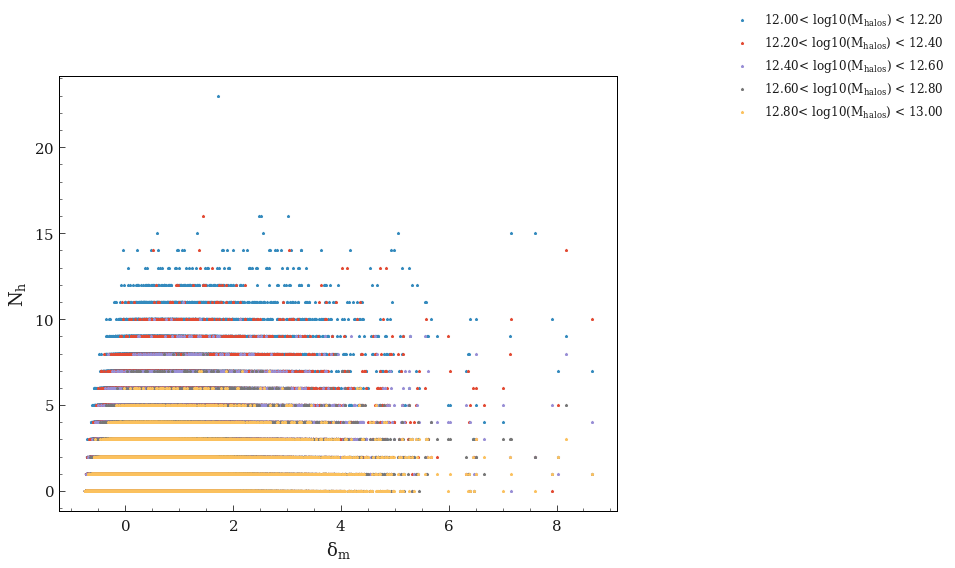

In [10]:
fig_and_ax = plt.subplots(figsize = (10, 8))
binned_slabs = []
for i, (M_min, M_max) in enumerate(zip(M_halo_bin_edges[:-1], M_halo_bin_edges[1:]), 0):
    mask_bin = (M_halo >= M_min) & (M_halo <= M_max)
    x_halo_bin = x_halo[mask_bin]
    y_halo_bin = y_halo[mask_bin]
    z_halo_bin = z_halo[mask_bin]
    halo_grid_bin = Slab.halo_catalog_to_grid(x_halo=x_halo_bin, y_halo=y_halo_bin, 
                                            z_halo=z_halo_bin, l_cube=1000, resol=256)
    
    delta_m_grid = Slab.delta_m_catalogue_to_grid(ix_matter= ix_matter, iy_matter=iy_matter, 
                                              iz_matter=iz_matter, delta_m=dens, resol=256)
    
    slabs_array = []
    for j in range(8):
        sim_slab = Slab(delta_m_3D=delta_m_grid, N_halos_3D=halo_grid_bin, N_slabs=8, rank = j, direction="z", L = 1000, ncells=4096)
        slabs_array.append(sim_slab)
    stacked_slabs = Slab.from_slabs(slabs_array = slabs_array, L = 1000)
    binned_slabs.append(stacked_slabs)
    ax, fig = stacked_slabs.plot_Nh_delta_m(fig_and_ax=fig_and_ax, Mmin=M_min, Mmax=M_max)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

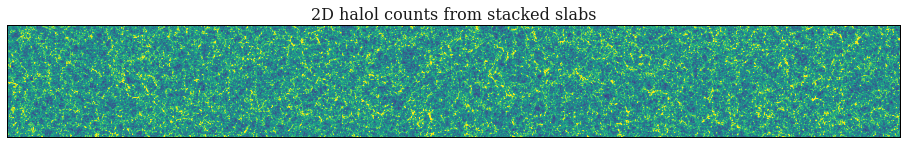

In [51]:
fig, ax = plt.subplots(figsize = (16, 10))
plt.imshow(binned_slabs[0].N_halos_2D, cmap='viridis', origin='lower', vmin=-1, vmax=5)
plt.xticks([])
plt.yticks([])
plt.title('2D halol counts from stacked slabs', fontsize=16)
fig.savefig('/Users/elyasfarah/Documents/Galaxy Bias/lib/figs_present/N_halos_2D_stacked_slabs.png', bbox_inches='tight', dpi=300)
# plt.colorbar(label='N_halos_2D', location  = 'bottom', aspect = 60)

Now, after splitting in slabs, it is good to bin the power spectrum in this case as follow:
1. Use the same binning scheme for every halo mass bin.
2. bin in delta_m_2D
3. Interpolate using cubic spline
4. adjust eh binning such that the function is as smooth as possible
5. Try to find initial guess for the sigmoid, including fixing some of the parameters.
The idea that the sigmoid with 4 parameter is flexible enough

In [52]:
def find_binned_counts(binned_model):
    delta_m_2D_bin_centers = binned_model.delta_m_2D_bin_mean
    Nh_counts = binned_model.N_halos_2D_bin_mean
    return delta_m_2D_bin_centers, Nh_counts

def find_turn_on_point(binned_model, N_th = 0.01):
    delta_m_2D, Nh = find_binned_counts(binned_model)
    mask = np.where(Nh >= N_th)
    Nh_masked = Nh[mask]
    delta_m_2D_masked = delta_m_2D[mask]
    return delta_m_2D_masked, Nh_masked 


def plot_masked_model(binned_model):
    delta_m, Nh = find_binned_counts(binned_model)
    delta_m_masked, Nh_maked = find_turn_on_point(binned_model)

    fig, ax = plt.subplots(1, 1, sharex=False, figsize = (12, 3))
    ax.plot(delta_m, Nh, color = "blue", marker = "+", label = "full range")
    ax.plot(delta_m_masked, Nh_maked, ls = "dashed",color = "red", marker = "o", ms = 3,label = "masked range")

    ax.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
    ax.set_ylabel(r"$N_{h}^{2D}$", fontsize= 14)

    ax.axvline(delta_m_masked[0], ls = "dashed", color = "black", label = "turn-on threshold")

    ax.set_title(rf"{np.log10(binned_model.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(binned_model.Mh_max):.2f}, $\delta_{{t}}$ = {delta_m_masked[0]:.2f}")


    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    return fig, ax

In [53]:
# preparing the bias model for inference
fixed_params_names = ["theta1", "theta2"]
fixed_params_values = [0, 0]
free_params_names = ["m1", "p1", "m2", "p2"]
bias_model = BiasModel.double_linear_bias_model()
theta_model = ThetaModel.linear_theta_model()

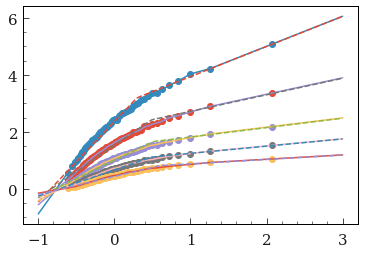

In [54]:
initial_guesses = []
delta_m_bins_list = []
covariances = []

x = []
y = []
for i, model in enumerate(binned_slabs, 0):
    delta_m, _ = find_turn_on_point(model)
    splined_bias_model = model.interpolated_bias_function(ncells = 2*4096, delta_m_cut = delta_m[0])
    delta_m_2D_sample = np.linspace(-1, 3, 100)
    popt, pcov = model.fit_bias_model_to_spline(initial_guess=(1, 0, 0.5, 1) , bias_model=bias_model, bias_relation_splined=splined_bias_model)
    initial_guesses.append(popt)
    covariances.append(np.diagonal(pcov))
    plt.plot(delta_m_2D_sample, splined_bias_model(delta_m_2D_sample))
    plt.plot(delta_m_2D_sample, bias_model.function(delta_m_2D_sample, m1 = popt[0], p1 = popt[1], m2 = popt[2], p2 = popt[3]), ls = "dashed")
    plt.scatter(model.delta_m_2D_bin_mean , model.N_halos_2D_bin_mean)


In [55]:
# split the simulation into halo mass bins
model1 = []
likelihood= []
delta_m_bins_list = []
for i, (stacked_slabs, Mh_min, Mh_max, initial_guess) in enumerate(zip(binned_slabs, M_halo_bin_edges[:-1], M_halo_bin_edges[1:], initial_guesses), 0):
    delta, _ = find_turn_on_point(stacked_slabs, N_th=0.05)
    
    popt, pcov, L = stacked_slabs.optimize_max_L_Poissonian(initial_guess=initial_guess, fixed_params_names=fixed_params_names, 
                                                            fixed_params_values = fixed_params_values, free_params_names=free_params_names, 
                                                            bias_model=bias_model, delta_m_cut = delta[0])

    
    model_binned = ModelComparison(slab_object=stacked_slabs, 
                                   bias_model=bias_model, theta_model=theta_model, parameters_names=free_params_names + fixed_params_names,
                                   parameters_values=list(popt) + fixed_params_values,
                                   Mh_min=Mh_min, Mh_max=Mh_max, delta_m_cut=delta[0])
    model1.append(model_binned)
    likelihood.append(L)

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [69]:
def plot_fits(self, nh_HOD, delta_HOD, color = "red", marker = None):
        quantities, quantities_errors = self.calculate_fits_in_bins()
        delta_m_2D_bin_centers = self.delta_m_2D_bin_mean
        N_halos_2D_model = self.bias_model.function(delta_m_2D_bin_centers, **self.parameters)
         
        fig, ax_counts = plt.subplots(1, 1, gridspec_kw={'height_ratios': [2]}, sharex=False, figsize = (10, 3))
        
        
        
        
        mask = (delta_m_2D_bin_centers > self.delta_m_cut)    
        ax_counts.plot(delta_m_2D_bin_centers[mask], N_halos_2D_model[mask], ls = "dashed", marker = marker, color = color, label = self.bias_model.name + " fit")
      
        
        ax_counts.errorbar(delta_m_2D_bin_centers, self.N_halos_2D_bin_mean, yerr = self.N_halos_2D_bin_error,
                          marker = "o", ms = 3, color = "black", label = "binned halo counts")
        

       

        ax_counts.plot(delta_HOD, nh_HOD, color = "blue", ls = "-.", label = "Shechter function expectation")
        
          
        # Get the current x axis limits
        x_min, x_max = ax_counts.get_xlim()
        
        # Make sure x_min is actually the minimum value by taking the minimum of the current xlim and data
        x_min = min(x_min, min(delta_m_2D_bin_centers))
        
        # Ensure the x_min is well below the minimum of your data points 
        # (giving a bit of extra space to ensure no white space at the edge)
        x_min = x_min - 0.05 * abs(x_max - x_min) 
        
        # Set the updated limits
        ax_counts.set_xlim(x_min, x_max)
        # Now apply the shading from the updated x_min to delta_m_cut
        ax_counts.axvspan(x_min, self.delta_m_cut, alpha=0.3, color='black', label='No halos region')

        ax_counts.set_ylabel(r"$N_{h}$", fontsize = 14)
        ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        ax_counts.set_title(rf"{np.log10(self.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(self.Mh_max):.2f}")
                
        
        # ax_stoch.errorbar(delta_m_2D_bin_centers, quantities["simulation"], yerr = quantities_errors["simulation"], 
        #             marker = "o", color= "black", label = "Simulation")
    
    
        
        ax_counts.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
            
        return  ax_counts, fig

In [70]:
nh_list_avg= np.load("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list.npy")
# nh_list_lower= np.load("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list_lower.npy")
# nh_list_higher= np.load("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list_upper.npy")

delta_m = np.linspace(-1, 3, 100)

Halo Mass Bin 0


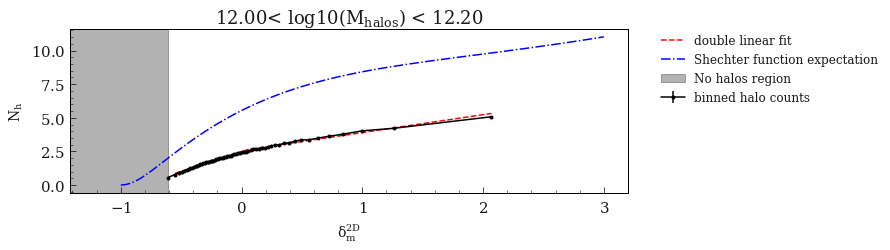

Halo Mass Bin 1


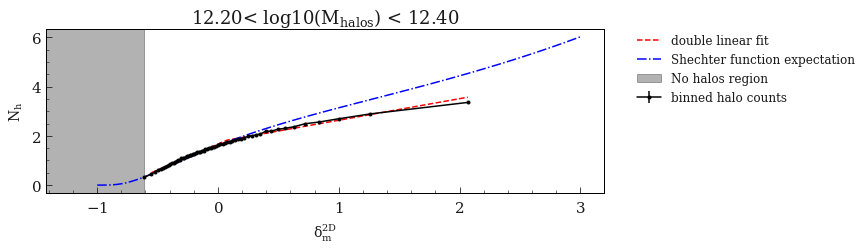

Halo Mass Bin 2


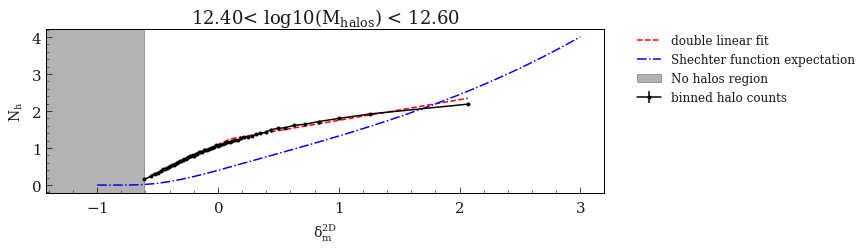

Halo Mass Bin 3


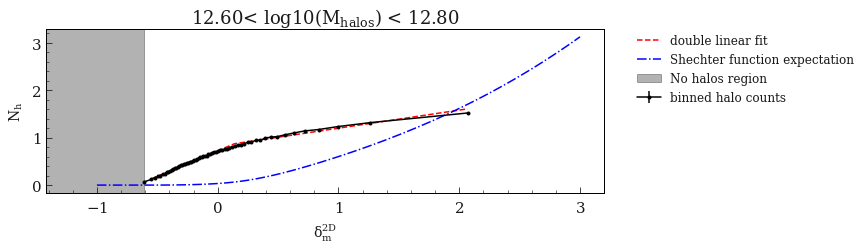

Halo Mass Bin 4


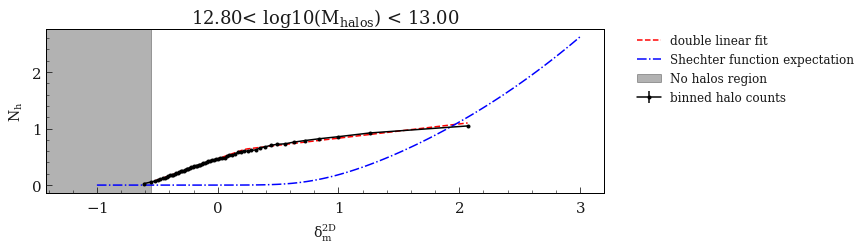

In [71]:
for i, bias1 in enumerate(model1, 0):
    print("Halo Mass Bin", i)
    ax_counts, fig = plot_fits(bias1,  nh_HOD= nh_list_avg[i], delta_HOD=delta_m , marker = None)
    # ax_counts.fill_between(delta_m, nh_list_lower[i], nh_list_higher[i], color = "blue", alpha = 0.3, label = "Shechter function uncertainty")
    ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # ax_counts.set_yscale("log")
    # ax_counts.set_xlim(-0.5, 1)
    # ax_stoch.set_xlim(-0.5, 1)
    print("===================")
    print("===================")
    # fig.savefig(f"/Users/elyasfarah/Documents/Galaxy Bias/lib/fig9/bin{i}.png",bbox_inches='tight')
    plt.show()

 


In [63]:
def plot_fits(self, nh_HOD, delta_HOD, color = "red", marker = None):
        quantities, quantities_errors = self.calculate_fits_in_bins()
        delta_m_2D_bin_centers = self.delta_m_2D_bin_mean
        N_halos_2D_model = self.bias_model.function(delta_m_2D_bin_centers, **self.parameters)
         
        fig, ax_counts = plt.subplots(1, 1, gridspec_kw={'height_ratios': [2]}, sharex=False, figsize = (10, 3))
        
        
        
        
        mask = (delta_m_2D_bin_centers > self.delta_m_cut)    
        # ax_counts.plot(delta_m_2D_bin_centers[mask], N_halos_2D_model[mask], ls = "dashed", marker = marker, color = color, label = self.bias_model.name + " fit")
      
        
        ax_counts.errorbar(delta_m_2D_bin_centers, self.N_halos_2D_bin_mean, yerr = self.N_halos_2D_bin_error,
                          marker = "o", ms = 3, color = "black", label = "binned halo counts")
        

       

        # ax_counts.plot(delta_HOD, nh_HOD, color = "blue", ls = "-.", label = "Shechter function expectation")
        
          
        # Get the current x axis limits
        x_min, x_max = ax_counts.get_xlim()
        
        # Make sure x_min is actually the minimum value by taking the minimum of the current xlim and data
        x_min = min(x_min, min(delta_m_2D_bin_centers))
        
        # Ensure the x_min is well below the minimum of your data points 
        # (giving a bit of extra space to ensure no white space at the edge)
        x_min = x_min - 0.05 * abs(x_max - x_min) 
        
        # Set the updated limits
        ax_counts.set_xlim(x_min, x_max)
        # Now apply the shading from the updated x_min to delta_m_cut
        ax_counts.axvspan(x_min, self.delta_m_cut, alpha=0.3, color='black', label='No halos region')

        ax_counts.set_ylabel(r"$N_{h}$", fontsize = 14)
        ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        ax_counts.set_title(rf"{np.log10(self.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(self.Mh_max):.2f}")
                
        
        # ax_stoch.errorbar(delta_m_2D_bin_centers, quantities["simulation"], yerr = quantities_errors["simulation"], 
        #             marker = "o", color= "black", label = "Simulation")
    
    
        
        ax_counts.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
            
        return  ax_counts, fig

Halo Mass Bin 0


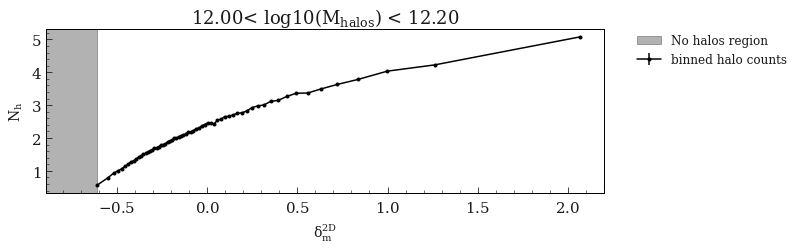

Halo Mass Bin 1


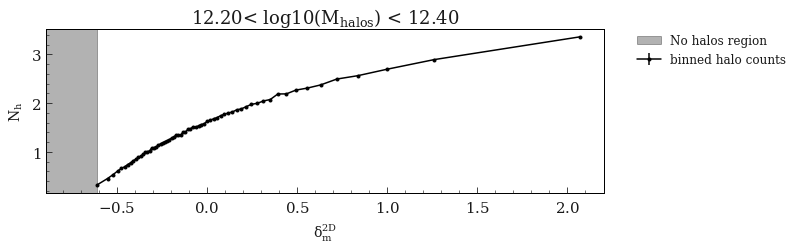

Halo Mass Bin 2


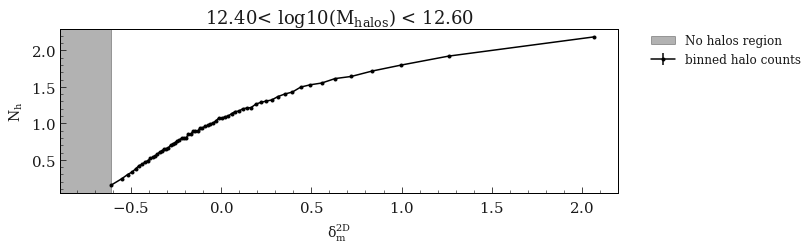

Halo Mass Bin 3


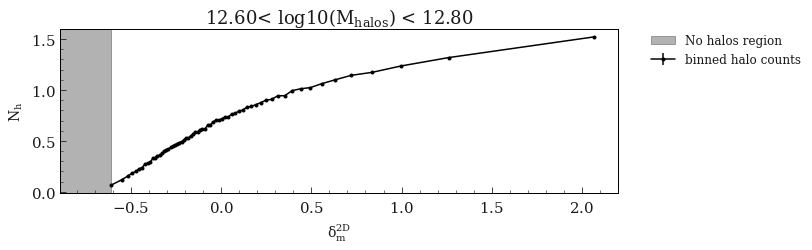

Halo Mass Bin 4


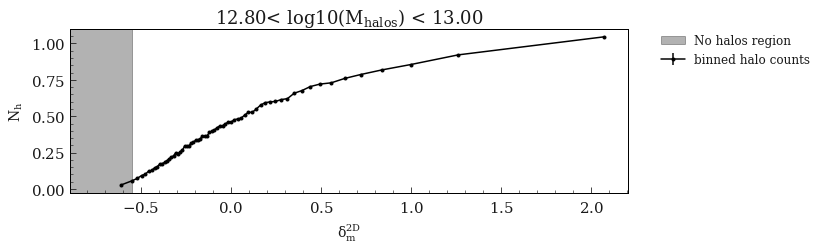

In [66]:
for i, bias1 in enumerate(model1, 0):
    print("Halo Mass Bin", i)
    ax_counts, fig = plot_fits(bias1,  nh_HOD= nh_list_avg[i], delta_HOD=delta_m , marker = None)
    # ax_counts.fill_between(delta_m, nh_list_lower[i], nh_list_higher[i], color = "blue", alpha = 0.3, label = "Shechter function uncertainty")
    ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    # ax_counts.set_yscale("log")
    # ax_counts.set_xlim(-0.5, 1)
    # ax_stoch.set_xlim(-0.5, 1)
    print("===================")
    print("===================")
    fig.savefig(f"/Users/elyasfarah/Documents/Galaxy Bias/lib/figs_present/bin{i}.png",bbox_inches='tight', dpi = 300)
    plt.show()

 


In [18]:
from scipy.interpolate import interp1d
def plot_error(self, nh_HOD, delta_HOD, color = "red", marker = None):
        delta_m_2D_bin_centers = self.delta_m_2D_bin_mean
        N_halos_2D_model = self.bias_model.function(delta_m_2D_bin_centers, **self.parameters)
         
        fig, (ax_counts, ax_err) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 2]}, sharex=False, figsize = (10, 6))
        
        
      
        
        ax_counts.errorbar(self.delta_m_2D_bin_mean, self.N_halos_2D_bin_mean, yerr = self.N_halos_2D_bin_error,
                          marker = "+", ms = 3, color = "black", label = "binned halo counts")
        ax_counts.plot(delta_HOD, nh_HOD, color = "blue", ls = "-.", label = "Conditional Mass expectation")
        ax_counts.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        ax_counts.set_ylabel(r"$N_{h}$", fontsize = 14)
        ax_counts.set_title(rf"{np.log10(self.Mh_min):.2f}< $log10(M_{{halos}})$ < {np.log10(self.Mh_max):.2f}")
        # interpolating each of the quantitites
        print(type( self.N_halos_2D_bin_mean))
        Nh_HOD_interp = interp1d(x = delta_HOD, y = nh_HOD,fill_value="extrapolate")
        Nh_sim_interp = interp1d(x = self.delta_m_2D_bin_mean, y = self.N_halos_2D_bin_mean, fill_value="extrapolate")
        
        
        ax_err.plot(delta_HOD, (Nh_sim_interp(delta_HOD)/Nh_HOD_interp(delta_HOD)) - 1, label = r'$\frac{N^{sim}}{N^{CM}} - 1$', color = 'red')
        ax_err.axhline(0, ls = 'dashed', color = 'black')
        ax_err.set_xlabel(r"$\delta_{m}^{2D}$", fontsize = 14)
        ax_err.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize = 20)
        return ax_counts, ax_err, fig
        
        
        

In [72]:
nh_list= np.load("/Users/elyasfarah/Documents/Galaxy Bias/lib/nh_list.npy")
delta_m = np.linspace(-1, 3, 100)
for i, bias1 in enumerate(model1, 0):
    print("Halo Mass Bin", i)
    ax_counts, ax_err, fig = plot_error(bias1,  nh_HOD= nh_list[i], delta_HOD=delta_m , marker = "o")
    # ax_counts.set_yscale('log')
    ax_err.set_ylim(-.2, .2)
    # fig.savefig(f"/Users/elyasfarah/Documents/Galaxy Bias/lib/figs5/sch_exp_log_bin{i}.png",bbox_inches='tight')
    # ax_counts.set_yscale('log')
    # ax_counts.set_xlim(-0.5, 1)
    # ax_stoch.set_xlim(-0.5, 1)
    print("===================")
    print("===================")
    plt.show()

Halo Mass Bin 0


NameError: name 'plot_error' is not defined

Finding the turn-on points of halo formation in each bin

In [ ]:
for i, bias in enumerate(model1, 0):
    fig, ax = plot_masked_model(bias)
    print("===================")
    print("===================")
    plt.show()

Plotting each of the parameters against the halo mass bin. Also, I plot the transition point from one linear function to another.

In [ ]:
a1_list = []
b1_list = []
a2_list = []
b2_list = []
delta_t2_list = []
n_bar = []


for i in model1:
    A = i.slab_object.find_A()
    n_bar.append(A)
    a1_list.append(i.parameters["m1"]/A)
    b1_list.append(i.parameters["p1"]/A)
    a2_list.append(i.parameters["m2"]/A)
    b2_list.append(i.parameters["p2"]/A)
    delta_t2_list.append((b2_list[-1] - b1_list[-1])/(a1_list[-1] - a2_list[-1]))   

In [ ]:
np.save("n_bar.npy", n_bar)

In [ ]:
fig, (ax_a1, ax_b1, ax_a2, ax_b2, ax_delta_t2) = plt.subplots(1, 5, figsize = (25, 4))
k = 1
ax_a1.plot(np.log10(M_halo_bin_center)[:-k], a1_list[:-k], marker = "o")
ax_b1.plot(np.log10(M_halo_bin_center)[:-k], b1_list[:-k], marker = "o")
ax_a2.plot(np.log10(M_halo_bin_center)[:-k], a2_list[:-k], marker = "o")
ax_b2.plot(np.log10(M_halo_bin_center)[:-k], b2_list[:-k], marker = "o")
ax_delta_t2.plot(np.log10(M_halo_bin_center)[:-k], delta_t2_list[:-k], marker = "o")

for i in [ax_a1, ax_b1, ax_a2, ax_b2, ax_delta_t2]:
    i.set_xlabel(r"$log10(M_{halo})$", fontsize = 16)
for i, j in zip([ax_a1, ax_b1, ax_a2, ax_b2], bias_model.parameters + [r"$\delta_t$"]):
    i.set_title(j + r"$/\bar{n}$")

ax_delta_t2.set_title(r"$\delta_t$")

plt.tight_layout()



In [ ]:
# Try to compare the skewness of the likelihood to the data.
# Try to capture the change of paramters as a function of resolution.
# Try the generalised ecponential that MPE prof suggested.